# WQ IV Momentum Strategy

Signal replication and long-short backtest for the Brain-inspired IV delta momentum idea.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

PROJECT_ROOT = Path("/Users/nikhileshbelulkar/Documents/saturate_the_hypersphere/smile_smirks")
DATA_PATH = PROJECT_ROOT / "processed_data" / "wq_iv_momentum_base.parquet"
RESULTS_DIR = PROJECT_ROOT / "processed_data"
SIGNAL_COL = "alpha_signal"

PROJECT_ROOT, DATA_PATH


(PosixPath('/Users/nikhileshbelulkar/Documents/saturate_the_hypersphere/smile_smirks'),
 PosixPath('/Users/nikhileshbelulkar/Documents/saturate_the_hypersphere/smile_smirks/processed_data/wq_iv_momentum_base.parquet'))

In [2]:
df = pd.read_parquet(DATA_PATH)
df = df.sort_values(["permno", "date"]).reset_index(drop=True)

print(df.shape)
df.head()


(479488, 12)


,secid,date,dte,iv_call60,opt_volume,opt_open_interest,moneyness,strike_price,permno,ticker,close,ret
0,106500,2020-02-18,59.0,0.318465,0.0,2.0,0.871536,150000.0,10026,JJSF,172.110001,-0.008526
1,106500,2020-02-19,58.0,0.285934,0.0,2.0,0.862366,150000.0,10026,JJSF,173.940002,0.010633
2,106500,2020-02-20,57.0,0.277421,0.0,2.0,0.859205,150000.0,10026,JJSF,174.580002,0.003679
3,106500,2020-02-21,56.0,0.314588,0.0,2.0,0.856947,150000.0,10026,JJSF,175.039993,0.002635
4,106500,2020-03-17,59.0,0.673859,0.0,1.0,1.128102,135000.0,10026,JJSF,119.669998,0.086132


In [3]:
DECAY_WINDOW = 25
DELTA_LAG = 25
TOP_Q = 0.2
BOTTOM_Q = 0.2

weights = np.arange(1, DECAY_WINDOW + 1, dtype=float)
weights = weights / weights.sum()


def decay_linear(series: pd.Series) -> pd.Series:
    return series.rolling(DECAY_WINDOW, min_periods=DECAY_WINDOW).apply(
        lambda x: np.dot(x, weights), raw=True
    )


def cs_zscore(series: pd.Series) -> pd.Series:
    std = series.std(ddof=0)
    if std == 0 or np.isnan(std):
        return pd.Series(np.nan, index=series.index)
    return (series - series.mean()) / std


def signed_power(x: pd.Series, power: int = 2) -> pd.Series:
    return np.sign(x) * (np.abs(x) ** power)



In [4]:
df["iv_delta"] = df.groupby("permno")["iv_call60"].diff(DELTA_LAG)
df["delta_positive"] = (df["iv_delta"] > 0).astype(float)
df["iv_trend_strength"] = df.groupby("permno")["delta_positive"].transform(decay_linear)

df["signal_z"] = df.groupby("date")["iv_trend_strength"].transform(cs_zscore)
df[SIGNAL_COL] = signed_power(df["signal_z"], 2)

signal_df = df.dropna(subset=[SIGNAL_COL, "ret"]).copy()

signal_df[["permno", "date", "iv_call60", SIGNAL_COL]].head()


,permno,date,iv_call60,alpha_signal
24,10026,2021-04-22,0.289233,-4.360767
25,10026,2021-04-23,0.289750,-4.034476
26,10026,2021-06-21,0.299351,-2.986656
27,10026,2021-06-22,0.285101,-1.751518
28,10026,2021-06-23,0.303767,-1.732056


In [5]:
summary = signal_df[[SIGNAL_COL]].describe(percentiles=[0.1, 0.5, 0.9])
summary


,alpha_signal
count,388504.000000
mean,0.005101
std,1.678188
min,-10.016402
10%,-1.675123
50%,-0.000037
90%,1.678687
max,20.614574


In [6]:
signal_df["rank_pct"] = signal_df.groupby("date")[SIGNAL_COL].rank(pct=True, method="first")


def calc_weights(group: pd.DataFrame) -> pd.Series:
    mask_long = group["rank_pct"] >= 1 - TOP_Q
    mask_short = group["rank_pct"] <= BOTTOM_Q
    weights = np.zeros(len(group), dtype=float)
    n_long = mask_long.sum()
    n_short = mask_short.sum()
    if n_long > 0:
        weights[mask_long.values] = 0.5 / n_long
    if n_short > 0:
        weights[mask_short.values] = -0.5 / n_short
    return pd.Series(weights, index=group.index)

signal_df["weight"] = signal_df.groupby("date", group_keys=False).apply(calc_weights)
signal_df.loc[:, ["date", "permno", SIGNAL_COL, "weight"]].head()


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_21270/3801046961.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_df["weight"] = signal_df.groupby("date", group_keys=False).apply(calc_weights)


,date,permno,alpha_signal,weight
24,2021-04-22,10026,-4.360767,-0.001134
25,2021-04-23,10026,-4.034476,-0.001111
26,2021-06-21,10026,-2.986656,-0.001316
27,2021-06-22,10026,-1.751518,-0.001174
28,2021-06-23,10026,-1.732056,-0.001139


In [7]:
signal_df["weight_lag"] = signal_df.groupby("permno")["weight"].shift(1)
signal_df["pnl"] = signal_df["weight_lag"] * signal_df["ret"]

daily_pnl = signal_df.groupby("date")["pnl"].sum().to_frame("daily_pnl").dropna()
daily_pnl["cum_return"] = (1 + daily_pnl["daily_pnl"]).cumprod() - 1
daily_pnl.head()


,daily_pnl,cum_return
date,,
2019-06-18,0.000000,0.000000
2019-06-19,0.001697,0.001697
2019-06-20,-0.004406,-0.002717
2019-06-21,0.000710,-0.002009
2019-07-22,0.003539,0.001523


In [8]:
TRADING_DAYS = 252
avg_daily = daily_pnl["daily_pnl"].mean()
vol_daily = daily_pnl["daily_pnl"].std(ddof=0)
ann_return = (1 + avg_daily) ** TRADING_DAYS - 1
ann_vol = vol_daily * np.sqrt(TRADING_DAYS)
sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
hit_rate = (daily_pnl["daily_pnl"] > 0).mean()

performance = {
    "ann_return": ann_return,
    "ann_vol": ann_vol,
    "sharpe": sharpe,
    "avg_daily": avg_daily,
    "daily_vol": vol_daily,
    "hit_rate": hit_rate
}
performance


{'ann_return': -0.09719179411685053,
 'ann_vol': 0.04680017389498107,
 'sharpe': -2.0767400209868354,
 'avg_daily': -0.00040565240203778544,
 'daily_vol': 0.0029481338438261187,
 'hit_rate': 0.4625}

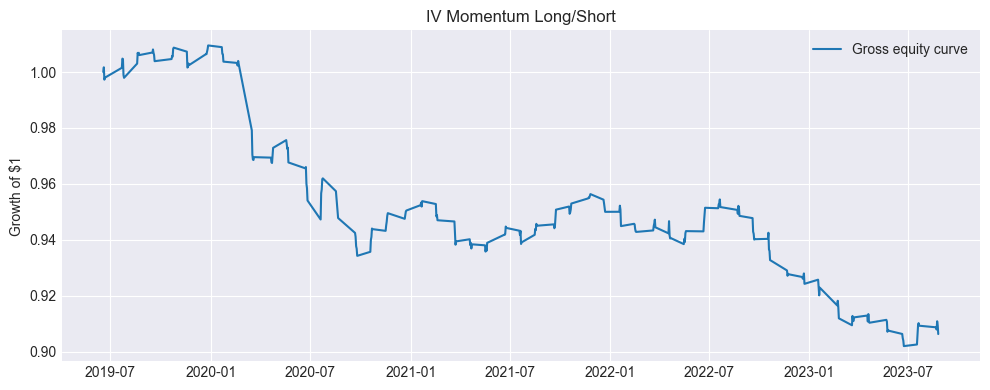

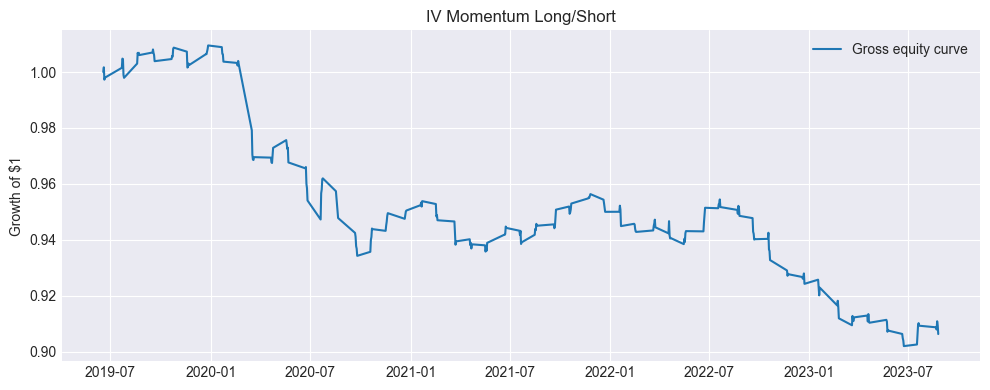

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily_pnl.index, (1 + daily_pnl["daily_pnl"]).cumprod(), label="Gross equity curve")
ax.set_title("IV Momentum Long/Short")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.tight_layout()
fig
